# Project: Customer Purchase Analytics Part I: Customer Analytics
Author: Wei Chong Ong

## Table of Contents
<ul>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#preprocessing">Data Preprocessing</a></li>
<li><a href="#segmentation">Customer Segmentation</a></li>
</ul>

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pickle

### Import Dataset

In [2]:
df_segmentation = pd.read_csv('customer data.csv', index_col = 0)

<a id='eda'></a>
## Exploratory Data Analysis

In [3]:
df_segmentation.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [4]:
df_segmentation.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


### Correlation Estimate
Use Pearson correlation method (linear dependency between the variables) to explore how the variables correlate to get an initial understanding of the relationship between them.  

In [5]:
# Compute Pearson correlation coefficient
df_segmentation.corr()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Sex,1.000000,0.566511,-0.182885,0.244838,-0.195146,-0.202491,-0.300803
Marital status,0.566511,1.000000,-0.213178,0.374017,-0.073528,-0.029490,-0.097041
Age,-0.182885,-0.213178,1.000000,0.654605,0.340610,0.108388,0.119751
Education,0.244838,0.374017,0.654605,1.000000,0.233459,0.064524,0.034732
Income,-0.195146,-0.073528,0.340610,0.233459,1.000000,0.680357,0.490881
Occupation,-0.202491,-0.029490,0.108388,0.064524,0.680357,1.000000,0.571795
Settlement size,-0.300803,-0.097041,0.119751,0.034732,0.490881,0.571795,1.000000


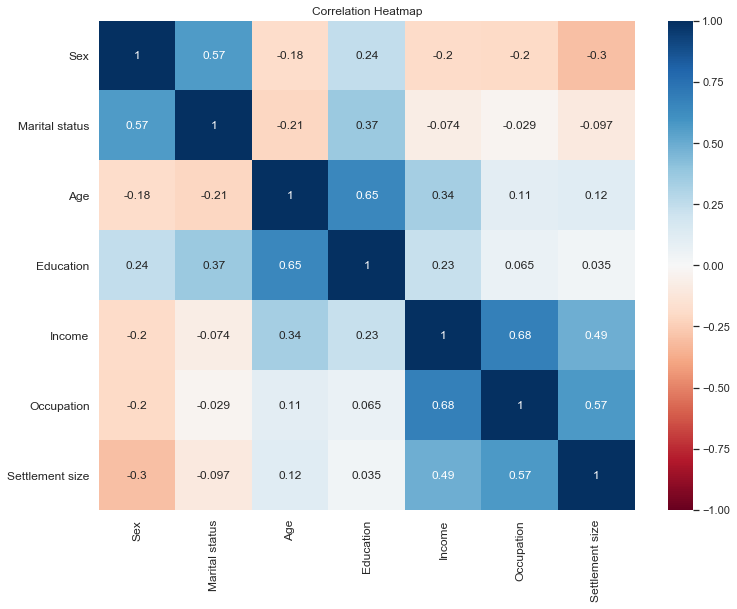

In [6]:
# Plot the correlations using a Heatmap
plt.figure(figsize = (12, 9))
s = sns.heatmap(df_segmentation.corr(),
               annot = True, 
               cmap = 'RdBu',
               vmin = -1, 
               vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

> There is a strong positive correlation between age and education of a value of 0.65, between income and occupation of a value of 0.68 and between occupation and settlement size of 0.57

<a id='preprocessing'></a>
## Data Preprocessing

### Standardization
Standardizing data, so that all features have equal weight, to avoid bias due to the large values of 'Income'. Transforming the variables in such a way that their values fall within the same numerical range.

In [7]:
# Standard Scaler
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df_segmentation)
df_segmentation_std = pd.DataFrame(data=segmentation_std) 
df_segmentation_std.columns = df_segmentation.columns
df_segmentation_std.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,-0.917399,-0.993024,2.653614,1.604323,0.097524,0.296823,1.552326
1,1.090038,1.007025,-1.187132,-0.063372,0.782654,0.296823,1.552326
2,-0.917399,-0.993024,1.117316,-0.063372,-0.833202,-1.269525,-0.909730
3,-0.917399,-0.993024,0.775916,-0.063372,1.328386,0.296823,0.321298
4,-0.917399,-0.993024,1.458716,-0.063372,0.736932,0.296823,0.321298


> Notes 
- StandardScaler removes the mean and scales each feature/variable to unit variance. This operation is performed feature-wise in an independent way.
- StandardScaler can be influenced by outliers (if they exist in the dataset) since it involves the estimation of the empirical mean and standard deviation of each feature.

<a id='segmentation'></a>
## Customer Segmentation

### K-means Clustering
- Calculated the within cluster sum of squares (WCSS) for each of the clustering solutions and used the WCSS values to determine the best clustering solution using elbow method
- k-means++ algorithm was used to find the best starting points for the centroid.

In [8]:
# Perform K-means clustering from 1 to 10 clusters
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(segmentation_std)
    wcss.append(kmeans.inertia_)

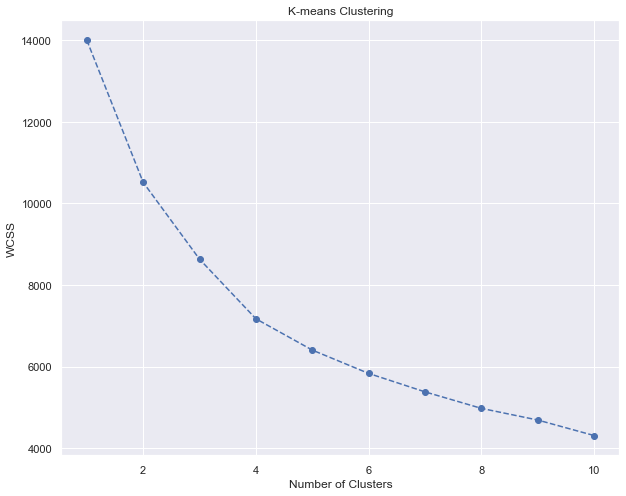

In [9]:
# Plot the Within Cluster Sum of Squares for the different number of clusters
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

> Four seems to be the optimal number of clusters

In [10]:
# Perform K-means clustering with K=4
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

# Fit the model into the standardized dataset
kmeans.fit(segmentation_std)

KMeans(n_clusters=4, random_state=42)

### Results and Interpretation - K-means Clustering

In [11]:
# Make a copy
df_segm_kmeans = df_segmentation.copy()

In [12]:
# Create a new column with the labels of each point
df_segm_kmeans['Segment K-means'] = kmeans.labels_

In [13]:
# Create a temporary dataframe with the aggregated information of each of the four clusters for easier interpretation
df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means']).mean()

# Compute the size and proportions of the four clusters
df_segm_analysis['N Obs'] = df_segm_kmeans[['Segment K-means','Sex']].groupby(['Segment K-means']).count()
df_segm_analysis['Prop Obs'] = df_segm_analysis['N Obs'] / df_segm_analysis['N Obs'].sum()

In [14]:
df_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N Obs,Prop Obs
Segment K-means,,,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
2,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850
3,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525


In [15]:
# Rename the four clusters with meaningful labels
df_segm_analysis.rename({0:'well-off',
                         1:'fewer-opportunities',
                         2:'career focused',
                         3:'standard'})

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N Obs,Prop Obs
Segment K-means,,,,,,,,,
well-off,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
fewer-opportunities,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
career focused,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850
standard,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525


> Clusters Interpretation:
- **well-off:** Oldest segment, more than 2/3 are in relationships, highest level of education and income, smallest segment
- **fewer-opportunities:** Mostly single, people in their thirties, relatively low education level and income, live in small cities
- **standard:** Youngest segment, people in relationships, medium level of education, average income and middle management jobs, largest segment
- **career focused:** Mostly men, less than 20% in relationships, relatively low education level, high income and occupation, majority live in big and middle size cities

In [16]:
# Label each of the data points with cluster name
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment K-means'].map({0:'well-off', 
                                                                  1:'fewer opportunities',
                                                                  2:'career focused', 
                                                                  3:'standard'})

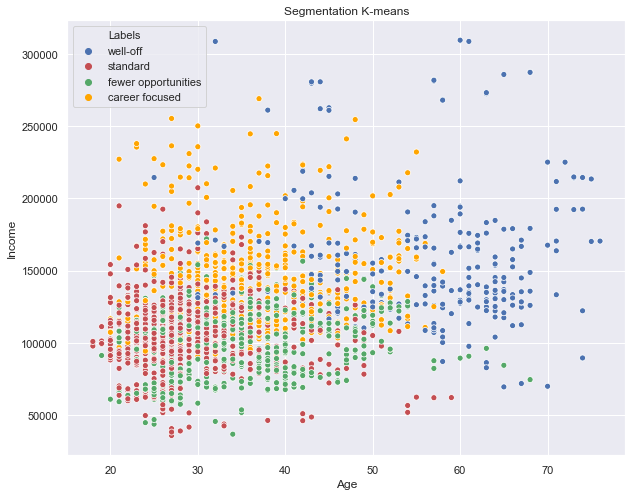

In [19]:
# Scatterplot for visualization
x_axis = df_segm_kmeans['Age']
y_axis = df_segm_kmeans['Income']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_kmeans['Labels'], palette = ['b', 'r', 'g', 'orange'])
plt.title('Segmentation K-means')
plt.show()

> We can see the blue segment 'well-off' is clearly separated as it is highest in both age and income. Unfortunately the other three are grouped together so it's harder to get more insight just by looking at the plot. In order to get a better clustering results, I'll combine k-means with principal component analysis.

### Principal Components Analysis - PCA
Apply dimensionality reduction to derive a low-dimensional set of features from a large set of variables.

In [20]:
# Initialize PCA
pca = PCA()

# Fit PCA with the standardized data.
pca.fit(segmentation_std)

# The attribute shows how much variance is explained by each of the seven individual components.
pca.explained_variance_ratio_

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

Text(0, 0.5, 'Cumulative Explained Variance')

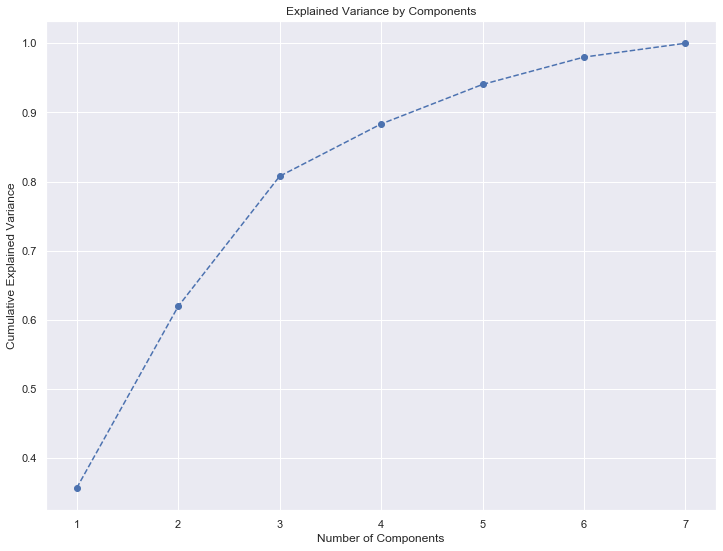

In [21]:
# Plot the cumulative variance explained by total number of components.
plt.figure(figsize = (12,9))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

> Three components was chosen to keep around 80 % of the explained variance.

In [22]:
# Three components
pca = PCA(n_components = 3)

pca.fit(segmentation_std)

PCA(n_components=3)

### Results and Interpretation - PCA

- The components attribute shows the loadings of each component on each of the seven original features.
- The loadings are the correlations between the components and the original features. 

In [23]:
# Create a dataframe of PCA results
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df_segmentation.columns.values,
                           index = ['Component 1', 'Component 2', 'Component 3'])
df_pca_comp

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Component 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
Component 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
Component 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


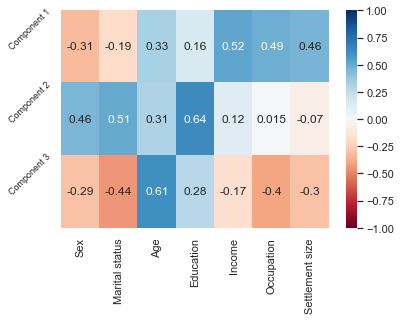

In [24]:
# Create a heatmap of the results for easier interpretation
sns.heatmap(df_pca_comp,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0, 1, 2], 
           ['Component 1', 'Component 2', 'Component 3'],
           rotation = 45,
           fontsize = 9);

> PCA Interpretation:
- There is a positive correlation between **component 1** and age, income, occupation and settlement size. Thus, this component shows the **career focus** of the individual.
- **Component 2** doesn't refer to the career but rather to an individual's **education and lifestyle**.
- Age, marital status and occupations are the most important determinants in the **component 3**. These indicate the **work experience and life experience**.

In [25]:
# Apply dimensionality reduction to the standardized dataset
scores_pca = pca.transform(segmentation_std)

### K-means Clustering with PCA

In [26]:
# Fit K means using the transformed data from the PCA
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

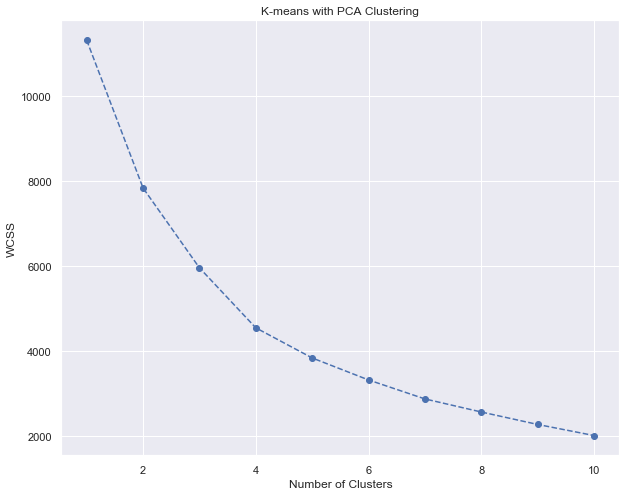

In [27]:
# Plot the Within Cluster Sum of Squares for the K-means PCA model
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

> Again, it looks like four is the best option.

In [28]:
# Perform K-means clustering with K=4
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

# Fit data with the k-means pca model (4 clusters, 3 components)
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=42)

### Results and Interpretation - K-means Clustering with PCA

In [29]:
# Create a new data frame with the original features and add the PCA scores and assigned clusters
df_segm_pca_kmeans = pd.concat([df_segmentation.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [30]:
df_segm_pca_kmeans

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Segment K-means PCA
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,3
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,2
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,0
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,1
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,1
...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,-0.866034,0.298330,1.438958,0
1996,1,1,27,1,117744,1,0,-1.114957,0.794727,-1.079871,2
1997,0,0,31,0,86400,0,0,-1.452298,-2.235937,0.896571,0
1998,1,1,24,1,97968,0,0,-2.241453,0.627108,-0.530456,2


In [31]:
# Calculate the means by segments
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3
Segment K-means PCA,,,,,,,,,,
0,0.307190,0.098039,35.383442,0.766885,93566.102397,0.248366,0.039216,-1.048838,-0.892116,1.010446
1,0.027350,0.167521,35.700855,0.731624,141489.721368,1.266667,1.475214,1.367167,-1.050209,-0.247981
2,0.900433,0.965368,28.913420,1.062049,107551.946609,0.676768,0.440115,-1.106918,0.706367,-0.778269
3,0.505703,0.688213,55.722433,2.129278,158391.676806,1.129278,1.110266,1.706153,2.031716,0.838839


In [32]:
# Calculate the size of each cluster and its proportion to the entire data set
df_segm_pca_kmeans_freq['N Obs'] = df_segm_pca_kmeans[['Segment K-means PCA','Sex']].groupby(['Segment K-means PCA']).count()
df_segm_pca_kmeans_freq['Prop Obs'] = df_segm_pca_kmeans_freq['N Obs'] / df_segm_pca_kmeans_freq['N Obs'].sum()

In [34]:
# Rename the four clusters with meaningful labels
df_segm_pca_kmeans_freq = df_segm_pca_kmeans_freq.rename({0:'fewer opportunities', 
                                                          1:'career focused',
                                                          2:'standard', 
                                                          3:'well-off'})
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,N Obs,Prop Obs
Segment K-means PCA,,,,,,,,,,,,
fewer opportunities,0.307190,0.098039,35.383442,0.766885,93566.102397,0.248366,0.039216,-1.048838,-0.892116,1.010446,459,0.2295
career focused,0.027350,0.167521,35.700855,0.731624,141489.721368,1.266667,1.475214,1.367167,-1.050209,-0.247981,585,0.2925
standard,0.900433,0.965368,28.913420,1.062049,107551.946609,0.676768,0.440115,-1.106918,0.706367,-0.778269,693,0.3465
well-off,0.505703,0.688213,55.722433,2.129278,158391.676806,1.129278,1.110266,1.706153,2.031716,0.838839,263,0.1315


> **Component 1: Career focus**   
**Component 2: Education and lifestyle**   
**Component 3: Work and life experience**   
- 'well-off' segment is highest on all three components 
- 'fewer-opportunities' segment has the lowest average PCA scores for component 1 and 2 but high on component 3
- 'career-focused' segment has high PCA scores for component 1 but low for component 2 and 3
- 'standard' segment is low on component 1 and 3 while normal to high on component 2

In [35]:
# Create a new column with the labels
df_segm_pca_kmeans['Legend'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0:'fewer opportunities', 
                                                          1:'career focused',
                                                          2:'standard', 
                                                          3:'well-off'})

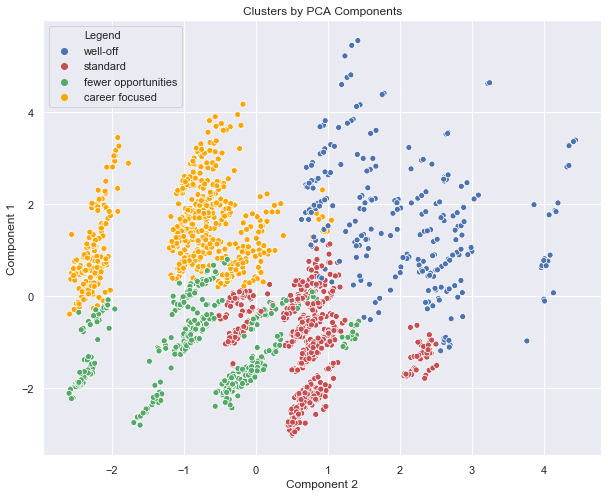

In [36]:
# Scatterplot for visualization
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_kmeans['Legend'], palette = ['b', 'r', 'g', 'orange'])
plt.title('Clusters by PCA Components')
plt.show()

> The division of the segments based on the components is much more pronounced with the help of PCA by reducing the number of variables by combining them into bigger, more meaningful features.

## Data Export
- Save the model by exporting the model files using pickle to later employ them in Part II Purchase Analytics.
- Pickle is a module used to turn Python objects into strings

Scaler to preprocess future data in the same way

In [37]:
pickle.dump(scaler, open('scaler.pickle', 'wb'))

PCA method and K-means with PCA to segment new data points based on the same criteria

In [38]:
pickle.dump(pca, open('pca.pickle', 'wb'))

In [39]:
pickle.dump(kmeans_pca, open('kmeans_pca.pickle', 'wb'))